## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle

## Loading data

In [2]:
with open('TSPDATA.txt', 'r') as f:
    data = [(int(line.split()[1]), int(line.split()[2])) for line in f.readlines()[2:]]

## Extracting needed information

In [3]:
n = len(data)
distance = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        distance[i, j] = np.sqrt((data[i][0]-data[j][0])**2 + (data[i][1]-data[j][1])**2)

## Individual, Fitness, Mutations, and crossovers

In [4]:
class Individual:
    def __init__(self, chromosome: np.ndarray):
        self.chromosome = chromosome
        self.fitness = None
        
    def calc_fitness(self) -> float:
        self.fitness = 0
        for i in range(len(self.chromosome)-1):
            self.fitness += distance[self.chromosome[i], self.chromosome[i+1]]
        self.fitness = 1 / self.fitness
        return self.fitness
    
    def swap_mutation(self):
        offspring = self.chromosome.copy()
        i, j = np.random.choice(np.arange(len(self.chromosome)), size=2, replace=False)
        offspring[i], offspring[j] = offspring[j], offspring[i]
        offspring = Individual(offspring)
        return offspring

    def insert_mutation(self):
        offspring = self.chromosome.copy()
        i = np.random.randint(0, len(self.chromosome))
        j = np.random.randint(0, len(self.chromosome))
        while abs(j-i) < 2:
            j = np.random.randint(0, len(self.chromosome))
        offspring = np.insert(offspring, min(i, j)+1, offspring[max(i, j)])
        offspring = np.delete(offspring, max(i, j)+1)
        offspring = Individual(offspring)
        return offspring
    
    @staticmethod
    def partially_mapped_crossover(parent1, parent2):
        parent1_chromosome = parent1.chromosome.copy()
        parent2_chromosome = parent2.chromosome.copy()
        cutoff_1, cutoff_2 = np.sort(np.random.choice(np.arange(len(parent1_chromosome)+1), size=2, replace=False))

        def pmx_one_offspring(p1, p2):
            offspring = np.zeros(len(p1), dtype=p1.dtype)
            offspring[cutoff_1:cutoff_2] = p1[cutoff_1:cutoff_2]
            for i in np.concatenate([np.arange(cutoff_1), np.arange(cutoff_2, len(p1))]):
                candidate = p2[i]
                while candidate in p1[cutoff_1:cutoff_2]:
                    candidate = p2[np.where(p1 == candidate)[0][0]]
                offspring[i] = candidate
            return offspring

        offspring1 = Individual(pmx_one_offspring(parent1_chromosome, parent2_chromosome))
        offspring2 = Individual(pmx_one_offspring(parent2_chromosome, parent1_chromosome))
        return offspring1, offspring2

    @staticmethod
    def edge_crossover(parent1, parent2) -> list:
        n = len(parent1.chromosome)
        def find_neighbors(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
            n = len(parent1)
            neighbors_array = np.full((n, 4, 2), -1)
            for i in range(n):
                neighbors_array[parent1[i]][0][0] = parent1[i-1]
                neighbors_array[parent1[i]][0][1] = 1
                neighbors_array[parent1[i]][1][0] = parent1[(i+1)%n]
                neighbors_array[parent1[i]][1][1] = 1
            for i in range(n):
                if parent2[i-1] == neighbors_array[parent2[i]][0][0]:
                    neighbors_array[parent2[i]][0][1] = 2
                elif parent2[i-1] == neighbors_array[parent2[i]][1][0]:
                    neighbors_array[parent2[i]][1][1] = 2
                elif neighbors_array[parent2[i]][2][0] == -1:
                    neighbors_array[parent2[i]][2][0] = parent2[i-1]
                    neighbors_array[parent2[i]][2][1] = 1
                else:
                    neighbors_array[parent2[i]][3][0] = parent2[i-1]
                    neighbors_array[parent2[i]][3][1] = 1
                if parent2[(i+1)%n] == neighbors_array[parent2[i]][0][0]:
                    neighbors_array[parent2[i]][0][0] = parent2[(i+1)%n]
                    neighbors_array[parent2[i]][0][1] = 2
                elif parent2[(i+1)%n] == neighbors_array[parent2[i]][1][0]:
                    neighbors_array[parent2[i]][1][0] = parent2[(i+1)%n]
                    neighbors_array[parent2[i]][1][1] = 2
                elif neighbors_array[parent2[i]][2][0] == -1:
                    neighbors_array[parent2[i]][2][0] = parent2[(i+1)%n]
                    neighbors_array[parent2[i]][2][1] = 1
                else:
                    neighbors_array[parent2[i]][3][0] = parent2[(i+1)%n]
                    neighbors_array[parent2[i]][3][1] = 1
            return neighbors_array

        neighbors_array = find_neighbors(parent1.chromosome, parent2.chromosome)

        def produce_one_offspring(selected_elements: np.ndarray):
    #         print(f"Choices: All\nElement Selected: {selected_elements[-1]}\nReason: Random\nPartial Result: {selected_elements}\n")
            i = 1
            while i < n:
                last_selected_element = selected_elements[i-1]
                common_neighbors = []
                normal_neighbors = []
                for neighbor in neighbors_array[last_selected_element]:
                    if neighbor[1] == 2 and neighbor[0] not in selected_elements:
                        common_neighbors.append(neighbor[0])
                    elif neighbor[0] != -1 and neighbor[0] not in selected_elements:
                        normal_neighbors.append(neighbor[0])
                if len(common_neighbors) > 0:
                    selected_elements[i] = np.random.choice(common_neighbors)
    #                 print(f"Choices: {common_neighbors + normal_neighbors}\nElement Selected: {selected_elements[-1]}")
    #                 if len(selected_elements) < n:
    #                     print(f"Reason: " + ("Only common neighbor" if len(common_neighbors) == 1 else "Multiple common neighbors have been found, one of them has been chosen randomly") if len(common_neighbors + normal_neighbors) > 1 else "Only item in list")
    #                 else:
    #                     print("Last element")
    #                 print(f"Partial Result: {selected_elements}\n")
                elif len(normal_neighbors) > 0:
                    neighbors_count = np.zeros(len(normal_neighbors))
                    for j in range(len(normal_neighbors)):
                        for neighbor in neighbors_array[normal_neighbors[j]]:
                            if neighbor[0] != -1 and neighbor[0] not in selected_elements:
                                neighbors_count[j] += 1
                    argmin_list = list(np.argwhere(neighbors_count == np.amin(neighbors_count)).reshape(-1))
                    random_selected_argmin = np.random.choice(argmin_list)
                    selected_elements[i] = normal_neighbors[random_selected_argmin]
    #                 print(f"Choices: {normal_neighbors}\nElement Selected: {selected_elements[-1]}")
    #                 if len(selected_elements) < n:
    #                     print(f"Reason: " + ("Only shortest list" if len(argmin_list) == 1 else "Multiple shortest lists have been found, one of them has been chosen randomly") if len(normal_neighbors) > 1 else "Only item in list")
    #                 else:
    #                     print("Last element")
    #                 print(f"Partial Result: {selected_elements}\n")
                else:
                    selected_elements[i] = np.random.choice(list(set(range(n)) - set(selected_elements)))
                i += 1
            return selected_elements

        offspring1_first_element, offspring2_first_element = np.random.choice(parent1.chromosome, size=2, replace=False)
        selected_elements = np.full(n, -1)
        selected_elements[0] = offspring1_first_element
        offspring1 = produce_one_offspring(selected_elements)
        selected_elements = np.full(n, -1)
        selected_elements[0] = offspring2_first_element
        offspring2 = produce_one_offspring(selected_elements)
        return Individual(offspring1), Individual(offspring2)

## Parent and survival selection functions

In [5]:
def linear_ranking(individuals_list: list[Individual], s=1.5):
    population_size = len(individuals_list)
    individuals_probs = []
    individuals_sorted = sorted(individuals_list, key=lambda x: x.fitness)
    for individual in individuals_list:
        i = individuals_sorted.index(individual)
        individuals_probs.append((2-s) / population_size + (2*i*(s-1)) / (population_size*(population_size-1)))
    return individuals_probs

def fitness_proportionate_selection(individuals_list: list[Individual]):
    individuals_probs = []
    fitness_sum = 0
    for individual in individuals_list:
        fitness_sum += individual.fitness
    for individual in individuals_list:
        individuals_probs.append(individual.fitness / fitness_sum)
    return individuals_probs

## Initialization

In [6]:
def initialize_population(population_size: int):
    x = np.array(np.arange(n))
    individuals_list = []
    for _ in range(population_size):
        np.random.shuffle(x)
        individual = Individual(x)
        individual.calc_fitness()
        individuals_list.append(individual)
    return individuals_list

## Running the algorithm

In [7]:
def run_algorithm(population_size: int, iterations_num: int, selection_method: str, crossover_method: str, mutation_method: str, p_mutation: float, s=1.5):
    individuals_list = initialize_population(population_size)
    best_individual_each_generation = []
    for generation in tqdm(range(iterations_num)):
        # assign selection probability to each individual
        if selection_method == 'linear_ranking':
            individuals_probs = linear_ranking(individuals_list, s=s)
        elif selection_method == 'fps':
            individuals_probs = fitness_proportionate_selection(individuals_list)    
        # do crossover and mutation
        offsprings_list = []
        for _ in range((3*population_size)//2):
            parent1, parent2 = np.random.choice(individuals_list, size=2, replace=False, p=individuals_probs)
            if crossover_method == 'pmx':
                offsprings_list.extend(Individual.partially_mapped_crossover(parent1, parent2))
            elif 'edge':
                offsprings_list.extend(Individual.edge_crossover(parent1, parent2))
        for offspring in offsprings_list:
            if np.random.rand() <= p_mutation:
                if mutation_method == 'swap':
                    offsprings_list.append(offspring.swap_mutation())
                elif mutation_method == 'insert':
                    offsprings_list.append(offspring.insert_mutation())
        # calculate offsprings' fitnesses
        for offspring in offsprings_list:
            offspring.calc_fitness()
        # assign selection probability to each individual
        if selection_method == 'linear_ranking':
            offsprings_probs = linear_ranking(offsprings_list, s=s)
        elif selection_method == 'fps':
            offsprings_probs = fitness_proportionate_selection(offsprings_list)
        
        best_individual_this_generation = max(individuals_list, key=lambda x: x.fitness)
        best_individual_each_generation.append(best_individual_this_generation)
        if generation % 10 == 0:
            print(f"best individual's total distances in generation {generation+1}: {1 / best_individual_this_generation.fitness}")
        # select POPULATION_SIZE individuals to survive
        individuals_list = np.random.choice(offsprings_list, size=population_size, replace=False, p=offsprings_probs)
    return individuals_list, best_individual_each_generation

### Hyperparamters

In [8]:
P_MUTATION = 0.1
POPULATION_SIZE = 100
ITERATIONS_NUM = 3000
S = 1.5

In [10]:
selection_methods = ['linear_ranking', 'fps']
crossover_methods = ['pmx', 'edge']
mutation_methods = ['swap', 'insert']
best_individual_each_generation_each_method = []
for selection_method in selection_methods:
    for crossover_method in crossover_methods:
        for mutation_method in mutation_methods:
            final_individuals_list, best_individual_each_generation = run_algorithm(population_size=POPULATION_SIZE, iterations_num=ITERATIONS_NUM, selection_method=selection_method, crossover_method=crossover_method, mutation_method=mutation_method, p_mutation=P_MUTATION)
            best_individual_each_generation_each_method.append(best_individual_each_generation)
            print(f"selection_method: {selection_method}, crossover_method: {crossover_method}, mutation_method: {mutation_method}")
            print(f"best achieved fitness: {1 / best_individual_each_generation[-1].fitness}\n")

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:08<00:00,  9.73it/s]


selection_method: linear_ranking, crossover_method: pmx, mutation_method: swap
best achieved fitness: 199810.32148703138



100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:48<00:00,  8.62it/s]


selection_method: linear_ranking, crossover_method: pmx, mutation_method: insert
best achieved fitness: 193842.27337625407



100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:29:04<00:00,  1.78s/it]


selection_method: linear_ranking, crossover_method: edge, mutation_method: swap
best achieved fitness: 240011.99935719528



100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [2:03:26<00:00,  2.47s/it]


selection_method: linear_ranking, crossover_method: edge, mutation_method: insert
best achieved fitness: 248311.29374973683



100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [08:14<00:00,  6.07it/s]


selection_method: fps, crossover_method: pmx, mutation_method: swap
best achieved fitness: 573769.0876876244



100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [08:17<00:00,  6.03it/s]


selection_method: fps, crossover_method: pmx, mutation_method: insert
best achieved fitness: 572465.6177772603



100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [2:04:44<00:00,  2.49s/it]


selection_method: fps, crossover_method: edge, mutation_method: swap
best achieved fitness: 546657.7641408825



100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [2:03:04<00:00,  2.46s/it]

selection_method: fps, crossover_method: edge, mutation_method: insert
best achieved fitness: 544642.3828048166



### Saving the results of the above cell

In [9]:
# with open('best_individual_each_generation_each_method.pkl', 'wb') as f:
#     pickle.dump(best_individual_each_generation_each_method, f, pickle.HIGHEST_PROTOCOL)

### Loading the saved results

In [10]:
with open('best_individual_each_generation_each_method.pkl', 'rb') as f:
    best_individual_each_generation_each_method = pickle.load(f)

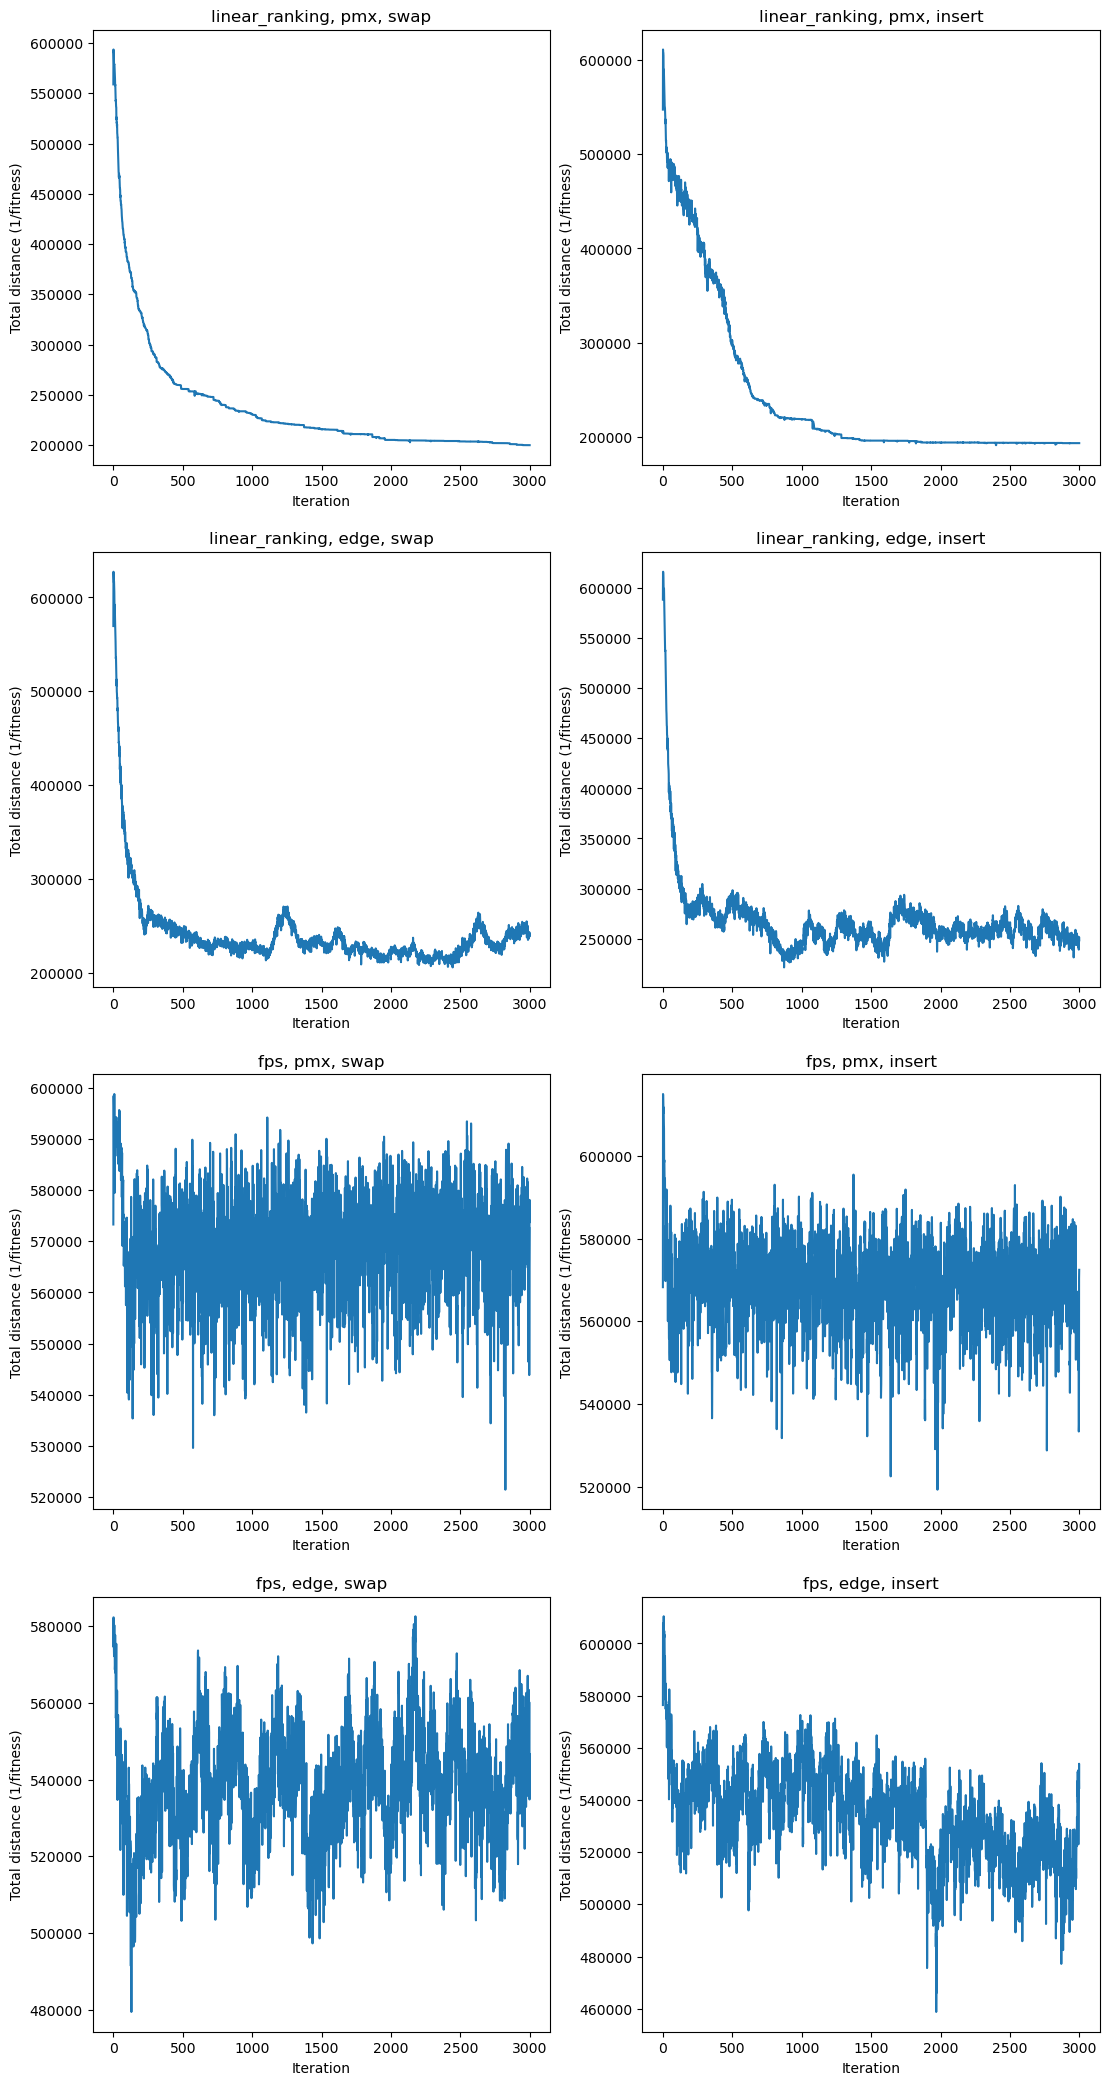

In [11]:
def plot_fig(figsize: tuple[int, int], rows: int, cols: int, data_list: tuple, title_list: tuple[str]) -> None:
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            ax[i, j].plot([1/individual.fitness for individual in data_list[i*cols+j]])
            ax[i, j].set_title(title_list[i*cols+j])
            ax[i, j].set_xlabel('Iteration')
            ax[i, j].set_ylabel('Total distance (1/fitness)')
    plt.show()

plot_fig(
    figsize=(13, 26), rows=4, cols=2, data_list=tuple(best_individual_each_generation_each_method), title_list=('linear_ranking, pmx, swap', 'linear_ranking, pmx, insert', 'linear_ranking, edge, swap', 'linear_ranking, edge, insert', 'fps, pmx, swap', 'fps, pmx, insert', 'fps, edge, swap', 'fps, edge, insert')
)

### Running the algorithm with the best hyperparamters combination for 10000 iterations

In [12]:
final_individuals_list, best_individual_each_generation = run_algorithm(population_size=1000, iterations_num=ITERATIONS_NUM, selection_method='linear_ranking', crossover_method='pmx', mutation_method='insert', p_mutation=P_MUTATION, s=S)
print("selection_method: Linear ranking, crossover_method: PMX, mutation_method: Insert")
print(f"best achieved fitness: {1 / best_individual_each_generation[-1].fitness}\n")

  0%|                                                                               | 1/3000 [00:02<2:25:13,  2.91s/it]

best individual's total distances in generation 1: 562126.4315261968


  0%|▎                                                                             | 11/3000 [00:16<1:12:26,  1.45s/it]

best individual's total distances in generation 11: 578866.0666095798


  1%|▌                                                                             | 21/3000 [00:32<1:21:42,  1.65s/it]

best individual's total distances in generation 21: 500020.2635721154


  1%|▊                                                                             | 31/3000 [00:50<1:26:36,  1.75s/it]

best individual's total distances in generation 31: 495113.88012373436


  1%|█                                                                             | 41/3000 [01:07<1:28:14,  1.79s/it]

best individual's total distances in generation 41: 484290.2655835781


  2%|█▎                                                                            | 51/3000 [01:26<1:28:28,  1.80s/it]

best individual's total distances in generation 51: 489010.8537933148


  2%|█▌                                                                            | 61/3000 [01:44<1:28:32,  1.81s/it]

best individual's total distances in generation 61: 490194.2538047342


  2%|█▊                                                                            | 71/3000 [02:02<1:27:41,  1.80s/it]

best individual's total distances in generation 71: 474302.54335263465


  3%|██                                                                            | 81/3000 [02:19<1:26:39,  1.78s/it]

best individual's total distances in generation 81: 469027.26087445783


  3%|██▎                                                                           | 91/3000 [02:38<1:27:20,  1.80s/it]

best individual's total distances in generation 91: 452382.8048125149


  3%|██▌                                                                          | 101/3000 [02:56<1:26:05,  1.78s/it]

best individual's total distances in generation 101: 455026.0097050822


  4%|██▊                                                                          | 111/3000 [03:13<1:25:29,  1.78s/it]

best individual's total distances in generation 111: 443959.7793385573


  4%|███                                                                          | 121/3000 [03:31<1:25:55,  1.79s/it]

best individual's total distances in generation 121: 441710.63178439235


  4%|███▎                                                                         | 131/3000 [03:49<1:24:59,  1.78s/it]

best individual's total distances in generation 131: 433456.0792409246


  5%|███▌                                                                         | 141/3000 [04:07<1:24:35,  1.78s/it]

best individual's total distances in generation 141: 408746.87526920915


  5%|███▉                                                                         | 151/3000 [04:25<1:24:04,  1.77s/it]

best individual's total distances in generation 151: 416239.9911132952


  5%|████▏                                                                        | 161/3000 [04:42<1:23:47,  1.77s/it]

best individual's total distances in generation 161: 426220.2851490271


  6%|████▍                                                                        | 171/3000 [05:00<1:22:44,  1.75s/it]

best individual's total distances in generation 171: 396151.1354593938


  6%|████▋                                                                        | 181/3000 [05:17<1:22:02,  1.75s/it]

best individual's total distances in generation 181: 389456.58562943886


  6%|████▉                                                                        | 191/3000 [05:35<1:21:53,  1.75s/it]

best individual's total distances in generation 191: 367463.95824629656


  7%|█████▏                                                                       | 201/3000 [05:52<1:21:30,  1.75s/it]

best individual's total distances in generation 201: 380644.5348545905


  7%|█████▍                                                                       | 211/3000 [06:10<1:20:41,  1.74s/it]

best individual's total distances in generation 211: 368815.4428881667


  7%|█████▋                                                                       | 221/3000 [06:27<1:20:13,  1.73s/it]

best individual's total distances in generation 221: 353512.8869926274


  8%|█████▉                                                                       | 231/3000 [06:45<1:20:19,  1.74s/it]

best individual's total distances in generation 231: 360576.4166202883


  8%|██████▏                                                                      | 241/3000 [07:02<1:19:17,  1.72s/it]

best individual's total distances in generation 241: 364948.1964924707


  8%|██████▍                                                                      | 251/3000 [07:19<1:19:06,  1.73s/it]

best individual's total distances in generation 251: 358623.288213471


  9%|██████▋                                                                      | 261/3000 [07:36<1:18:30,  1.72s/it]

best individual's total distances in generation 261: 349176.9752862741


  9%|██████▉                                                                      | 271/3000 [07:54<1:17:46,  1.71s/it]

best individual's total distances in generation 271: 345721.1454648358


  9%|███████▏                                                                     | 281/3000 [08:11<1:17:00,  1.70s/it]

best individual's total distances in generation 281: 339327.22207342164


 10%|███████▍                                                                     | 291/3000 [08:27<1:16:04,  1.68s/it]

best individual's total distances in generation 291: 330892.81961014564


 10%|███████▋                                                                     | 301/3000 [08:44<1:15:38,  1.68s/it]

best individual's total distances in generation 301: 326798.8210879621


 10%|███████▉                                                                     | 311/3000 [09:01<1:15:22,  1.68s/it]

best individual's total distances in generation 311: 323704.7432835377


 11%|████████▏                                                                    | 321/3000 [09:18<1:14:54,  1.68s/it]

best individual's total distances in generation 321: 329062.61495137337


 11%|████████▍                                                                    | 331/3000 [09:35<1:14:34,  1.68s/it]

best individual's total distances in generation 331: 319652.5693067913


 11%|████████▊                                                                    | 341/3000 [09:52<1:14:59,  1.69s/it]

best individual's total distances in generation 341: 316818.4194065566


 12%|█████████                                                                    | 351/3000 [10:09<1:13:56,  1.67s/it]

best individual's total distances in generation 351: 309647.36205089785


 12%|█████████▎                                                                   | 361/3000 [10:25<1:14:19,  1.69s/it]

best individual's total distances in generation 361: 304602.0659764738


 12%|█████████▌                                                                   | 371/3000 [10:42<1:14:00,  1.69s/it]

best individual's total distances in generation 371: 315295.9328747482


 13%|█████████▊                                                                   | 381/3000 [10:59<1:13:16,  1.68s/it]

best individual's total distances in generation 381: 316519.8120324906


 13%|██████████                                                                   | 391/3000 [11:16<1:12:49,  1.67s/it]

best individual's total distances in generation 391: 311442.4098144418


 13%|██████████▎                                                                  | 401/3000 [11:33<1:11:56,  1.66s/it]

best individual's total distances in generation 401: 304698.84939192835


 14%|██████████▌                                                                  | 411/3000 [11:49<1:10:09,  1.63s/it]

best individual's total distances in generation 411: 302069.8209381204


 14%|██████████▊                                                                  | 421/3000 [12:05<1:09:56,  1.63s/it]

best individual's total distances in generation 421: 300756.73081341764


 14%|███████████                                                                  | 431/3000 [12:21<1:09:53,  1.63s/it]

best individual's total distances in generation 431: 292596.4883697865


 15%|███████████▎                                                                 | 441/3000 [12:38<1:09:43,  1.63s/it]

best individual's total distances in generation 441: 301601.2218802273


 15%|███████████▌                                                                 | 451/3000 [12:54<1:09:31,  1.64s/it]

best individual's total distances in generation 451: 294439.9309565974


 15%|███████████▊                                                                 | 461/3000 [13:10<1:08:54,  1.63s/it]

best individual's total distances in generation 461: 302935.216335458


 16%|████████████                                                                 | 471/3000 [13:27<1:08:30,  1.63s/it]

best individual's total distances in generation 471: 288469.5938476185


 16%|████████████▎                                                                | 481/3000 [13:43<1:08:26,  1.63s/it]

best individual's total distances in generation 481: 292257.0052338904


 16%|████████████▌                                                                | 491/3000 [13:59<1:07:49,  1.62s/it]

best individual's total distances in generation 491: 284644.1394366695


 17%|████████████▊                                                                | 501/3000 [14:15<1:07:03,  1.61s/it]

best individual's total distances in generation 501: 283264.9412397929


 17%|█████████████                                                                | 511/3000 [14:31<1:06:27,  1.60s/it]

best individual's total distances in generation 511: 286209.73230799165


 17%|█████████████▎                                                               | 521/3000 [14:47<1:05:38,  1.59s/it]

best individual's total distances in generation 521: 284136.4771041253


 18%|█████████████▋                                                               | 531/3000 [15:03<1:05:15,  1.59s/it]

best individual's total distances in generation 531: 283447.48334900104


 18%|█████████████▉                                                               | 541/3000 [15:19<1:04:28,  1.57s/it]

best individual's total distances in generation 541: 277122.8029788594


 18%|██████████████▏                                                              | 551/3000 [15:35<1:04:16,  1.57s/it]

best individual's total distances in generation 551: 271810.5599549894


 19%|██████████████▍                                                              | 561/3000 [15:50<1:03:45,  1.57s/it]

best individual's total distances in generation 561: 272180.86952120136


 19%|██████████████▋                                                              | 571/3000 [16:06<1:03:12,  1.56s/it]

best individual's total distances in generation 571: 275552.30584795494


 19%|██████████████▉                                                              | 581/3000 [16:22<1:02:44,  1.56s/it]

best individual's total distances in generation 581: 274758.77543850185


 20%|███████████████▏                                                             | 591/3000 [16:37<1:02:43,  1.56s/it]

best individual's total distances in generation 591: 271317.0606494928


 20%|███████████████▍                                                             | 601/3000 [16:53<1:01:38,  1.54s/it]

best individual's total distances in generation 601: 268457.02422392694


 20%|███████████████▋                                                             | 611/3000 [17:08<1:01:43,  1.55s/it]

best individual's total distances in generation 611: 265326.7891869227


 21%|███████████████▉                                                             | 621/3000 [17:24<1:00:50,  1.53s/it]

best individual's total distances in generation 621: 260870.39435463105


 21%|████████████████▏                                                            | 631/3000 [17:39<1:00:18,  1.53s/it]

best individual's total distances in generation 631: 255993.24331874144


 21%|████████████████▍                                                            | 641/3000 [17:54<1:00:10,  1.53s/it]

best individual's total distances in generation 641: 255490.63766988146


 22%|█████████████████▏                                                             | 651/3000 [18:09<58:27,  1.49s/it]

best individual's total distances in generation 651: 249183.7247207164


 22%|█████████████████▍                                                             | 661/3000 [18:24<57:22,  1.47s/it]

best individual's total distances in generation 661: 247675.4213234348


 22%|█████████████████▋                                                             | 671/3000 [18:39<57:23,  1.48s/it]

best individual's total distances in generation 671: 241138.9500188517


 23%|█████████████████▉                                                             | 681/3000 [18:53<56:42,  1.47s/it]

best individual's total distances in generation 681: 236559.62419268192


 23%|██████████████████▏                                                            | 691/3000 [19:08<55:59,  1.46s/it]

best individual's total distances in generation 691: 225492.96760318283


 23%|██████████████████▍                                                            | 701/3000 [19:23<55:59,  1.46s/it]

best individual's total distances in generation 701: 224564.76208895197


 24%|██████████████████▋                                                            | 711/3000 [19:37<55:15,  1.45s/it]

best individual's total distances in generation 711: 224393.5329213871


 24%|██████████████████▉                                                            | 721/3000 [19:52<54:50,  1.44s/it]

best individual's total distances in generation 721: 223250.23066457675


 24%|███████████████████▏                                                           | 731/3000 [20:06<54:05,  1.43s/it]

best individual's total distances in generation 731: 216886.45440762726


 25%|███████████████████▌                                                           | 741/3000 [20:20<53:20,  1.42s/it]

best individual's total distances in generation 741: 215099.01563562363


 25%|███████████████████▊                                                           | 751/3000 [20:34<52:37,  1.40s/it]

best individual's total distances in generation 751: 209841.0432983418


 25%|████████████████████                                                           | 761/3000 [20:48<51:50,  1.39s/it]

best individual's total distances in generation 761: 207720.6292022994


 26%|████████████████████▎                                                          | 771/3000 [21:02<51:33,  1.39s/it]

best individual's total distances in generation 771: 203143.30035719214


 26%|████████████████████▌                                                          | 781/3000 [21:16<50:35,  1.37s/it]

best individual's total distances in generation 781: 198338.13143314366


 26%|████████████████████▊                                                          | 791/3000 [21:29<49:14,  1.34s/it]

best individual's total distances in generation 791: 195153.69557675405


 27%|█████████████████████                                                          | 801/3000 [21:43<48:39,  1.33s/it]

best individual's total distances in generation 801: 189328.07935602954


 27%|█████████████████████▎                                                         | 811/3000 [21:56<47:43,  1.31s/it]

best individual's total distances in generation 811: 184044.41219118086


 27%|█████████████████████▌                                                         | 821/3000 [22:09<46:56,  1.29s/it]

best individual's total distances in generation 821: 180710.38646024076


 28%|█████████████████████▉                                                         | 831/3000 [22:21<45:08,  1.25s/it]

best individual's total distances in generation 831: 178699.8741403092


 28%|██████████████████████▏                                                        | 841/3000 [22:34<44:09,  1.23s/it]

best individual's total distances in generation 841: 174857.6228220763


 28%|██████████████████████▍                                                        | 851/3000 [22:46<43:55,  1.23s/it]

best individual's total distances in generation 851: 171708.17240317678


 29%|██████████████████████▋                                                        | 861/3000 [22:58<43:08,  1.21s/it]

best individual's total distances in generation 861: 169903.2543052858


 29%|██████████████████████▉                                                        | 871/3000 [23:10<42:56,  1.21s/it]

best individual's total distances in generation 871: 166903.79607084097


 29%|███████████████████████▏                                                       | 881/3000 [23:22<42:19,  1.20s/it]

best individual's total distances in generation 881: 165939.722307654


 30%|███████████████████████▍                                                       | 891/3000 [23:34<42:11,  1.20s/it]

best individual's total distances in generation 891: 165173.1647437318


 30%|███████████████████████▋                                                       | 901/3000 [23:46<41:27,  1.19s/it]

best individual's total distances in generation 901: 163013.28953997174


 30%|███████████████████████▉                                                       | 911/3000 [23:58<41:33,  1.19s/it]

best individual's total distances in generation 911: 164148.47678849075


 31%|████████████████████████▎                                                      | 921/3000 [24:10<41:49,  1.21s/it]

best individual's total distances in generation 921: 163790.74978711442


 31%|████████████████████████▌                                                      | 931/3000 [24:22<41:00,  1.19s/it]

best individual's total distances in generation 931: 162859.55249694813


 31%|████████████████████████▊                                                      | 941/3000 [24:34<40:41,  1.19s/it]

best individual's total distances in generation 941: 162026.10129481432


 32%|█████████████████████████                                                      | 951/3000 [24:46<40:34,  1.19s/it]

best individual's total distances in generation 951: 159856.0054094769


 32%|█████████████████████████▎                                                     | 961/3000 [24:57<40:30,  1.19s/it]

best individual's total distances in generation 961: 160427.47198447617


 32%|█████████████████████████▌                                                     | 971/3000 [25:09<40:32,  1.20s/it]

best individual's total distances in generation 971: 159610.10278087226


 33%|█████████████████████████▊                                                     | 981/3000 [25:21<40:07,  1.19s/it]

best individual's total distances in generation 981: 159350.4691399122


 33%|██████████████████████████                                                     | 991/3000 [25:33<39:50,  1.19s/it]

best individual's total distances in generation 991: 157356.78122583055


 33%|██████████████████████████                                                    | 1001/3000 [25:45<39:38,  1.19s/it]

best individual's total distances in generation 1001: 158755.22239056852


 34%|██████████████████████████▎                                                   | 1011/3000 [25:57<39:09,  1.18s/it]

best individual's total distances in generation 1011: 158596.21337101635


 34%|██████████████████████████▌                                                   | 1021/3000 [26:09<39:04,  1.18s/it]

best individual's total distances in generation 1021: 157569.49003883795


 34%|██████████████████████████▊                                                   | 1031/3000 [26:21<38:48,  1.18s/it]

best individual's total distances in generation 1031: 157058.21133884546


 35%|███████████████████████████                                                   | 1041/3000 [26:32<38:23,  1.18s/it]

best individual's total distances in generation 1041: 156438.41083651918


 35%|███████████████████████████▎                                                  | 1051/3000 [26:44<38:14,  1.18s/it]

best individual's total distances in generation 1051: 156400.8763147422


 35%|███████████████████████████▌                                                  | 1061/3000 [26:56<38:32,  1.19s/it]

best individual's total distances in generation 1061: 156111.3389830663


 36%|███████████████████████████▊                                                  | 1071/3000 [27:08<38:47,  1.21s/it]

best individual's total distances in generation 1071: 155883.7983677413


 36%|████████████████████████████                                                  | 1081/3000 [27:20<38:22,  1.20s/it]

best individual's total distances in generation 1081: 155633.57353349225


 36%|████████████████████████████▎                                                 | 1091/3000 [27:32<38:05,  1.20s/it]

best individual's total distances in generation 1091: 155445.95576957086


 37%|████████████████████████████▋                                                 | 1101/3000 [27:44<38:12,  1.21s/it]

best individual's total distances in generation 1101: 155315.88769269947


 37%|████████████████████████████▉                                                 | 1111/3000 [27:56<37:32,  1.19s/it]

best individual's total distances in generation 1111: 155040.2659276167


 37%|█████████████████████████████▏                                                | 1121/3000 [28:08<37:32,  1.20s/it]

best individual's total distances in generation 1121: 154429.1501260321


 38%|█████████████████████████████▍                                                | 1131/3000 [28:20<36:50,  1.18s/it]

best individual's total distances in generation 1131: 153657.74351099384


 38%|█████████████████████████████▋                                                | 1141/3000 [28:32<36:50,  1.19s/it]

best individual's total distances in generation 1141: 153403.7727190006


 38%|█████████████████████████████▉                                                | 1151/3000 [28:44<36:29,  1.18s/it]

best individual's total distances in generation 1151: 153324.4116913244


 39%|██████████████████████████████▏                                               | 1161/3000 [28:56<36:21,  1.19s/it]

best individual's total distances in generation 1161: 153098.3763657529


 39%|██████████████████████████████▍                                               | 1171/3000 [29:08<35:57,  1.18s/it]

best individual's total distances in generation 1171: 152929.05217703205


 39%|██████████████████████████████▋                                               | 1181/3000 [29:19<36:01,  1.19s/it]

best individual's total distances in generation 1181: 152796.8135655423


 40%|██████████████████████████████▉                                               | 1191/3000 [29:31<35:43,  1.18s/it]

best individual's total distances in generation 1191: 150897.0235109865


 40%|███████████████████████████████▏                                              | 1201/3000 [29:43<35:33,  1.19s/it]

best individual's total distances in generation 1201: 149559.7905893108


 40%|███████████████████████████████▍                                              | 1211/3000 [29:55<35:19,  1.18s/it]

best individual's total distances in generation 1211: 149427.55197782107


 41%|███████████████████████████████▋                                              | 1221/3000 [30:07<35:02,  1.18s/it]

best individual's total distances in generation 1221: 149273.47106643944


 41%|████████████████████████████████                                              | 1231/3000 [30:19<34:44,  1.18s/it]

best individual's total distances in generation 1231: 149175.36075610112


 41%|████████████████████████████████▎                                             | 1241/3000 [30:31<34:53,  1.19s/it]

best individual's total distances in generation 1241: 149305.087519381


 42%|████████████████████████████████▌                                             | 1251/3000 [30:42<34:53,  1.20s/it]

best individual's total distances in generation 1251: 149005.12929516635


 42%|████████████████████████████████▊                                             | 1261/3000 [30:54<34:21,  1.19s/it]

best individual's total distances in generation 1261: 148811.24746556501


 42%|█████████████████████████████████                                             | 1271/3000 [31:06<34:41,  1.20s/it]

best individual's total distances in generation 1271: 148847.61069673876


 43%|█████████████████████████████████▎                                            | 1281/3000 [31:18<34:17,  1.20s/it]

best individual's total distances in generation 1281: 148838.78117118523


 43%|█████████████████████████████████▌                                            | 1291/3000 [31:30<34:00,  1.19s/it]

best individual's total distances in generation 1291: 148752.9380734464


 43%|█████████████████████████████████▊                                            | 1301/3000 [31:42<33:49,  1.19s/it]

best individual's total distances in generation 1301: 148645.49408141075


 44%|██████████████████████████████████                                            | 1311/3000 [31:54<33:20,  1.18s/it]

best individual's total distances in generation 1311: 148645.49408141075


 44%|██████████████████████████████████▎                                           | 1321/3000 [32:06<32:39,  1.17s/it]

best individual's total distances in generation 1321: 148042.88301520844


 44%|██████████████████████████████████▌                                           | 1331/3000 [32:17<32:34,  1.17s/it]

best individual's total distances in generation 1331: 148114.64233191643


 45%|██████████████████████████████████▊                                           | 1341/3000 [32:29<32:23,  1.17s/it]

best individual's total distances in generation 1341: 148232.10142565097


 45%|███████████████████████████████████▏                                          | 1351/3000 [32:41<32:01,  1.17s/it]

best individual's total distances in generation 1351: 148288.32270606494


 45%|███████████████████████████████████▍                                          | 1361/3000 [32:52<31:51,  1.17s/it]

best individual's total distances in generation 1361: 148481.1213644841


 46%|███████████████████████████████████▋                                          | 1371/3000 [33:04<32:49,  1.21s/it]

best individual's total distances in generation 1371: 148345.5886607062


 46%|███████████████████████████████████▉                                          | 1381/3000 [33:16<31:19,  1.16s/it]

best individual's total distances in generation 1381: 148232.10142565097


 46%|████████████████████████████████████▏                                         | 1391/3000 [33:28<31:27,  1.17s/it]

best individual's total distances in generation 1391: 148232.0359772485


 47%|████████████████████████████████████▍                                         | 1401/3000 [33:39<30:57,  1.16s/it]

best individual's total distances in generation 1401: 148171.11437355427


 47%|████████████████████████████████████▋                                         | 1411/3000 [33:51<30:43,  1.16s/it]

best individual's total distances in generation 1411: 148163.92620574535


 47%|████████████████████████████████████▉                                         | 1421/3000 [34:03<30:44,  1.17s/it]

best individual's total distances in generation 1421: 148029.95289193589


 48%|█████████████████████████████████████▏                                        | 1431/3000 [34:14<30:17,  1.16s/it]

best individual's total distances in generation 1431: 148117.71811177584


 48%|█████████████████████████████████████▍                                        | 1441/3000 [34:26<30:12,  1.16s/it]

best individual's total distances in generation 1441: 148017.6235399067


 48%|█████████████████████████████████████▋                                        | 1451/3000 [34:37<29:49,  1.16s/it]

best individual's total distances in generation 1451: 147791.23273307498


 49%|█████████████████████████████████████▉                                        | 1461/3000 [34:49<29:47,  1.16s/it]

best individual's total distances in generation 1461: 147845.31636992763


 49%|██████████████████████████████████████▏                                       | 1471/3000 [35:01<29:34,  1.16s/it]

best individual's total distances in generation 1471: 148094.40175716323


 49%|██████████████████████████████████████▌                                       | 1481/3000 [35:12<29:15,  1.16s/it]

best individual's total distances in generation 1481: 147886.68720643758


 50%|██████████████████████████████████████▊                                       | 1491/3000 [35:24<29:05,  1.16s/it]

best individual's total distances in generation 1491: 148094.40175716323


 50%|███████████████████████████████████████                                       | 1501/3000 [35:35<29:06,  1.17s/it]

best individual's total distances in generation 1501: 148094.40175716323


 50%|███████████████████████████████████████▎                                      | 1511/3000 [35:47<28:46,  1.16s/it]

best individual's total distances in generation 1511: 148094.40175716323


 51%|███████████████████████████████████████▌                                      | 1521/3000 [35:59<28:45,  1.17s/it]

best individual's total distances in generation 1521: 148094.40175716323


 51%|███████████████████████████████████████▊                                      | 1531/3000 [36:10<28:20,  1.16s/it]

best individual's total distances in generation 1531: 147491.79069096092


 51%|████████████████████████████████████████                                      | 1541/3000 [36:22<28:00,  1.15s/it]

best individual's total distances in generation 1541: 147842.21053544327


 52%|████████████████████████████████████████▎                                     | 1551/3000 [36:33<28:22,  1.17s/it]

best individual's total distances in generation 1551: 147809.5065173259


 52%|████████████████████████████████████████▌                                     | 1561/3000 [36:45<27:58,  1.17s/it]

best individual's total distances in generation 1561: 147842.21053544327


 52%|████████████████████████████████████████▊                                     | 1571/3000 [36:57<28:03,  1.18s/it]

best individual's total distances in generation 1571: 147842.21053544327


 53%|█████████████████████████████████████████                                     | 1581/3000 [37:09<28:19,  1.20s/it]

best individual's total distances in generation 1581: 147709.35373754124


 53%|█████████████████████████████████████████▎                                    | 1591/3000 [37:20<27:21,  1.17s/it]

best individual's total distances in generation 1591: 147593.12514820768


 53%|█████████████████████████████████████████▋                                    | 1601/3000 [37:32<26:57,  1.16s/it]

best individual's total distances in generation 1601: 147709.35373754124


 54%|█████████████████████████████████████████▉                                    | 1611/3000 [37:44<26:49,  1.16s/it]

best individual's total distances in generation 1611: 147709.35373754124


 54%|██████████████████████████████████████████▏                                   | 1621/3000 [37:55<26:28,  1.15s/it]

best individual's total distances in generation 1621: 147587.62401271288


 54%|██████████████████████████████████████████▍                                   | 1631/3000 [38:07<26:28,  1.16s/it]

best individual's total distances in generation 1631: 147586.3674263152


 55%|██████████████████████████████████████████▋                                   | 1641/3000 [38:19<26:29,  1.17s/it]

best individual's total distances in generation 1641: 147543.00561356012


 55%|██████████████████████████████████████████▉                                   | 1651/3000 [38:30<26:41,  1.19s/it]

best individual's total distances in generation 1651: 147358.9338930589


 55%|███████████████████████████████████████████▏                                  | 1661/3000 [38:42<26:18,  1.18s/it]

best individual's total distances in generation 1661: 147358.9338930589


 56%|███████████████████████████████████████████▍                                  | 1671/3000 [38:54<25:59,  1.17s/it]

best individual's total distances in generation 1671: 147109.8485058233


 56%|███████████████████████████████████████████▋                                  | 1681/3000 [39:06<25:49,  1.17s/it]

best individual's total distances in generation 1681: 147074.2099247305


 56%|███████████████████████████████████████████▉                                  | 1691/3000 [39:18<26:05,  1.20s/it]

best individual's total distances in generation 1691: 147238.28668066853


 57%|████████████████████████████████████████████▏                                 | 1701/3000 [39:29<25:13,  1.17s/it]

best individual's total distances in generation 1701: 147214.0286217992


 57%|████████████████████████████████████████████▍                                 | 1711/3000 [39:41<25:07,  1.17s/it]

best individual's total distances in generation 1711: 146594.22811947291


 57%|████████████████████████████████████████████▋                                 | 1721/3000 [39:53<24:43,  1.16s/it]

best individual's total distances in generation 1721: 146964.9432345636


 58%|█████████████████████████████████████████████                                 | 1731/3000 [40:04<24:33,  1.16s/it]

best individual's total distances in generation 1731: 147047.68049781807


 58%|█████████████████████████████████████████████▎                                | 1741/3000 [40:16<24:23,  1.16s/it]

best individual's total distances in generation 1741: 147214.0286217992


 58%|█████████████████████████████████████████████▌                                | 1751/3000 [40:27<24:10,  1.16s/it]

best individual's total distances in generation 1751: 147214.0286217992


 59%|█████████████████████████████████████████████▊                                | 1761/3000 [40:39<23:54,  1.16s/it]

best individual's total distances in generation 1761: 147214.0286217992


 59%|██████████████████████████████████████████████                                | 1771/3000 [40:51<23:47,  1.16s/it]

best individual's total distances in generation 1771: 146964.9432345636


 59%|██████████████████████████████████████████████▎                               | 1781/3000 [41:02<23:25,  1.15s/it]

best individual's total distances in generation 1781: 146964.9432345636


 60%|██████████████████████████████████████████████▌                               | 1791/3000 [41:14<23:23,  1.16s/it]

best individual's total distances in generation 1791: 146964.9432345636


 60%|██████████████████████████████████████████████▊                               | 1801/3000 [41:26<23:21,  1.17s/it]

best individual's total distances in generation 1801: 146964.9432345636


 60%|███████████████████████████████████████████████                               | 1811/3000 [41:37<23:48,  1.20s/it]

best individual's total distances in generation 1811: 146964.9432345636


 61%|███████████████████████████████████████████████▎                              | 1821/3000 [41:49<23:45,  1.21s/it]

best individual's total distances in generation 1821: 146964.9432345636


 61%|███████████████████████████████████████████████▌                              | 1831/3000 [42:02<23:38,  1.21s/it]

best individual's total distances in generation 1831: 146964.9432345636


 61%|███████████████████████████████████████████████▊                              | 1841/3000 [42:13<22:19,  1.16s/it]

best individual's total distances in generation 1841: 146964.9432345636


 62%|████████████████████████████████████████████████▏                             | 1851/3000 [42:25<22:06,  1.15s/it]

best individual's total distances in generation 1851: 144668.08629639368


 62%|████████████████████████████████████████████████▍                             | 1861/3000 [42:37<22:26,  1.18s/it]

best individual's total distances in generation 1861: 144844.10387411105


 62%|████████████████████████████████████████████████▋                             | 1871/3000 [42:48<22:20,  1.19s/it]

best individual's total distances in generation 1871: 144844.10387411105


 63%|████████████████████████████████████████████████▉                             | 1881/3000 [43:00<22:24,  1.20s/it]

best individual's total distances in generation 1881: 144844.10387411105


 63%|█████████████████████████████████████████████████▏                            | 1891/3000 [43:13<22:26,  1.21s/it]

best individual's total distances in generation 1891: 144844.10387411105


 63%|█████████████████████████████████████████████████▍                            | 1901/3000 [43:24<21:06,  1.15s/it]

best individual's total distances in generation 1901: 144844.10387411105


 64%|█████████████████████████████████████████████████▋                            | 1911/3000 [43:36<21:15,  1.17s/it]

best individual's total distances in generation 1911: 144844.10387411105


 64%|█████████████████████████████████████████████████▉                            | 1921/3000 [43:47<20:51,  1.16s/it]

best individual's total distances in generation 1921: 144291.35699899154


 64%|██████████████████████████████████████████████████▏                           | 1931/3000 [43:59<20:44,  1.16s/it]

best individual's total distances in generation 1931: 144803.2439917


 65%|██████████████████████████████████████████████████▍                           | 1941/3000 [44:11<20:33,  1.16s/it]

best individual's total distances in generation 1941: 144800.5138992733


 65%|██████████████████████████████████████████████████▋                           | 1951/3000 [44:23<20:43,  1.19s/it]

best individual's total distances in generation 1951: 144800.5138992733


 65%|██████████████████████████████████████████████████▉                           | 1961/3000 [44:34<20:01,  1.16s/it]

best individual's total distances in generation 1961: 144800.5138992733


 66%|███████████████████████████████████████████████████▏                          | 1971/3000 [44:46<19:54,  1.16s/it]

best individual's total distances in generation 1971: 144247.76702415379


 66%|███████████████████████████████████████████████████▌                          | 1981/3000 [44:57<19:45,  1.16s/it]

best individual's total distances in generation 1981: 144800.5138992733


 66%|███████████████████████████████████████████████████▊                          | 1991/3000 [45:09<19:35,  1.17s/it]

best individual's total distances in generation 1991: 144800.5138992733


 67%|████████████████████████████████████████████████████                          | 2001/3000 [45:21<19:17,  1.16s/it]

best individual's total distances in generation 2001: 144800.5138992733


 67%|████████████████████████████████████████████████████▎                         | 2011/3000 [45:32<19:06,  1.16s/it]

best individual's total distances in generation 2011: 144595.26762611623


 67%|████████████████████████████████████████████████████▌                         | 2021/3000 [45:44<18:51,  1.16s/it]

best individual's total distances in generation 2021: 144595.26762611623


 68%|████████████████████████████████████████████████████▊                         | 2031/3000 [45:55<18:43,  1.16s/it]

best individual's total distances in generation 2031: 144497.34487518505


 68%|█████████████████████████████████████████████████████                         | 2041/3000 [46:07<18:30,  1.16s/it]

best individual's total distances in generation 2041: 144800.5138992733


 68%|█████████████████████████████████████████████████████▎                        | 2051/3000 [46:19<18:17,  1.16s/it]

best individual's total distances in generation 2051: 144800.5138992733


 69%|█████████████████████████████████████████████████████▌                        | 2061/3000 [46:30<18:11,  1.16s/it]

best individual's total distances in generation 2061: 144796.56260214362


 69%|█████████████████████████████████████████████████████▊                        | 2071/3000 [46:42<17:52,  1.15s/it]

best individual's total distances in generation 2071: 144247.76702415379


 69%|██████████████████████████████████████████████████████                        | 2081/3000 [46:53<17:51,  1.17s/it]

best individual's total distances in generation 2081: 144595.26762611623


 70%|██████████████████████████████████████████████████████▎                       | 2091/3000 [47:05<17:27,  1.15s/it]

best individual's total distances in generation 2091: 144800.5138992733


 70%|██████████████████████████████████████████████████████▋                       | 2101/3000 [47:17<17:20,  1.16s/it]

best individual's total distances in generation 2101: 144800.5138992733


 70%|██████████████████████████████████████████████████████▉                       | 2111/3000 [47:28<17:07,  1.16s/it]

best individual's total distances in generation 2111: 144800.5138992733


 71%|███████████████████████████████████████████████████████▏                      | 2121/3000 [47:40<16:55,  1.16s/it]

best individual's total distances in generation 2121: 144800.5138992733


 71%|███████████████████████████████████████████████████████▍                      | 2131/3000 [47:51<16:51,  1.16s/it]

best individual's total distances in generation 2131: 144800.5138992733


 71%|███████████████████████████████████████████████████████▋                      | 2141/3000 [48:03<16:33,  1.16s/it]

best individual's total distances in generation 2141: 144800.5138992733


 72%|███████████████████████████████████████████████████████▉                      | 2151/3000 [48:15<16:26,  1.16s/it]

best individual's total distances in generation 2151: 142503.6569611034


 72%|████████████████████████████████████████████████████████▏                     | 2161/3000 [48:26<16:15,  1.16s/it]

best individual's total distances in generation 2161: 144748.19850629446


 72%|████████████████████████████████████████████████████████▍                     | 2171/3000 [48:38<15:50,  1.15s/it]

best individual's total distances in generation 2171: 144800.5138992733


 73%|████████████████████████████████████████████████████████▋                     | 2181/3000 [48:49<15:44,  1.15s/it]

best individual's total distances in generation 2181: 144800.5138992733


 73%|████████████████████████████████████████████████████████▉                     | 2191/3000 [49:01<15:34,  1.16s/it]

best individual's total distances in generation 2191: 144180.71339694702


 73%|█████████████████████████████████████████████████████████▏                    | 2201/3000 [49:12<15:31,  1.17s/it]

best individual's total distances in generation 2201: 144247.76702415379


 74%|█████████████████████████████████████████████████████████▍                    | 2211/3000 [49:24<15:14,  1.16s/it]

best individual's total distances in generation 2211: 144247.76702415379


 74%|█████████████████████████████████████████████████████████▋                    | 2221/3000 [49:36<15:10,  1.17s/it]

best individual's total distances in generation 2221: 144247.76702415379


 74%|██████████████████████████████████████████████████████████                    | 2231/3000 [49:48<15:06,  1.18s/it]

best individual's total distances in generation 2231: 142503.6569611034


 75%|██████████████████████████████████████████████████████████▎                   | 2241/3000 [50:00<15:19,  1.21s/it]

best individual's total distances in generation 2241: 144247.76702415379


 75%|██████████████████████████████████████████████████████████▌                   | 2251/3000 [50:12<14:43,  1.18s/it]

best individual's total distances in generation 2251: 144243.81572702414


 75%|██████████████████████████████████████████████████████████▊                   | 2261/3000 [50:23<14:26,  1.17s/it]

best individual's total distances in generation 2261: 144195.45163117495


 76%|███████████████████████████████████████████████████████████                   | 2271/3000 [50:35<14:11,  1.17s/it]

best individual's total distances in generation 2271: 144243.81572702414


 76%|███████████████████████████████████████████████████████████▎                  | 2281/3000 [50:47<14:22,  1.20s/it]

best individual's total distances in generation 2281: 144243.81572702414


 76%|███████████████████████████████████████████████████████████▌                  | 2291/3000 [50:59<13:50,  1.17s/it]

best individual's total distances in generation 2291: 143624.01522469785


 77%|███████████████████████████████████████████████████████████▊                  | 2301/3000 [51:10<13:31,  1.16s/it]

best individual's total distances in generation 2301: 144221.79211353112


 77%|████████████████████████████████████████████████████████████                  | 2311/3000 [51:22<13:36,  1.18s/it]

best individual's total distances in generation 2311: 141946.95878885424


 77%|████████████████████████████████████████████████████████████▎                 | 2321/3000 [51:34<13:09,  1.16s/it]

best individual's total distances in generation 2321: 143918.62308944287


 78%|████████████████████████████████████████████████████████████▌                 | 2331/3000 [51:45<12:56,  1.16s/it]

best individual's total distances in generation 2331: 144218.2753257887


 78%|████████████████████████████████████████████████████████████▊                 | 2341/3000 [51:57<12:44,  1.16s/it]

best individual's total distances in generation 2341: 144095.37252851305


 78%|█████████████████████████████████████████████████████████████▏                | 2351/3000 [52:09<12:33,  1.16s/it]

best individual's total distances in generation 2351: 143598.4748234624


 79%|█████████████████████████████████████████████████████████████▍                | 2361/3000 [52:20<12:21,  1.16s/it]

best individual's total distances in generation 2361: 144095.37252851305


 79%|█████████████████████████████████████████████████████████████▋                | 2371/3000 [52:32<12:13,  1.17s/it]

best individual's total distances in generation 2371: 143915.10630170046


 79%|█████████████████████████████████████████████████████████████▉                | 2381/3000 [52:43<12:02,  1.17s/it]

best individual's total distances in generation 2381: 144095.37252851305


 80%|██████████████████████████████████████████████████████████████▏               | 2391/3000 [52:55<12:05,  1.19s/it]

best individual's total distances in generation 2391: 144095.37252851305


 80%|██████████████████████████████████████████████████████████████▍               | 2401/3000 [53:07<11:36,  1.16s/it]

best individual's total distances in generation 2401: 144095.37252851305


 80%|██████████████████████████████████████████████████████████████▋               | 2411/3000 [53:19<11:23,  1.16s/it]

best individual's total distances in generation 2411: 144095.37252851305


 81%|██████████████████████████████████████████████████████████████▉               | 2421/3000 [53:30<11:13,  1.16s/it]

best individual's total distances in generation 2421: 144095.37252851305


 81%|███████████████████████████████████████████████████████████████▏              | 2431/3000 [53:42<10:58,  1.16s/it]

best individual's total distances in generation 2431: 144095.37252851305


 81%|███████████████████████████████████████████████████████████████▍              | 2441/3000 [53:53<10:54,  1.17s/it]

best individual's total distances in generation 2441: 144095.37252851305


 82%|███████████████████████████████████████████████████████████████▋              | 2451/3000 [54:05<10:32,  1.15s/it]

best individual's total distances in generation 2451: 144095.37252851305


 82%|███████████████████████████████████████████████████████████████▉              | 2461/3000 [54:17<10:27,  1.16s/it]

best individual's total distances in generation 2461: 144095.37252851305


 82%|████████████████████████████████████████████████████████████████▏             | 2471/3000 [54:28<10:16,  1.17s/it]

best individual's total distances in generation 2471: 144095.37252851305


 83%|████████████████████████████████████████████████████████████████▌             | 2481/3000 [54:40<10:02,  1.16s/it]

best individual's total distances in generation 2481: 144095.37252851305


 83%|████████████████████████████████████████████████████████████████▊             | 2491/3000 [54:52<09:48,  1.16s/it]

best individual's total distances in generation 2491: 144095.37252851305


 83%|█████████████████████████████████████████████████████████████████             | 2501/3000 [55:03<09:38,  1.16s/it]

best individual's total distances in generation 2501: 144095.37252851305


 84%|█████████████████████████████████████████████████████████████████▎            | 2511/3000 [55:15<09:26,  1.16s/it]

best individual's total distances in generation 2511: 141798.51559034316


 84%|█████████████████████████████████████████████████████████████████▌            | 2521/3000 [55:26<09:19,  1.17s/it]

best individual's total distances in generation 2521: 143741.55191053453


 84%|█████████████████████████████████████████████████████████████████▊            | 2531/3000 [55:38<09:12,  1.18s/it]

best individual's total distances in generation 2531: 143716.0983480765


 85%|██████████████████████████████████████████████████████████████████            | 2541/3000 [55:50<08:53,  1.16s/it]

best individual's total distances in generation 2541: 143716.0983480765


 85%|██████████████████████████████████████████████████████████████████▎           | 2551/3000 [56:01<08:41,  1.16s/it]

best individual's total distances in generation 2551: 143536.52645152647


 85%|██████████████████████████████████████████████████████████████████▌           | 2561/3000 [56:13<08:26,  1.15s/it]

best individual's total distances in generation 2561: 143716.0983480765


 86%|██████████████████████████████████████████████████████████████████▊           | 2571/3000 [56:24<08:15,  1.15s/it]

best individual's total distances in generation 2571: 143716.0983480765


 86%|███████████████████████████████████████████████████████████████████           | 2581/3000 [56:36<08:05,  1.16s/it]

best individual's total distances in generation 2581: 143716.0983480765


 86%|███████████████████████████████████████████████████████████████████▎          | 2591/3000 [56:48<07:53,  1.16s/it]

best individual's total distances in generation 2591: 143716.0983480765


 87%|███████████████████████████████████████████████████████████████████▋          | 2601/3000 [56:59<07:42,  1.16s/it]

best individual's total distances in generation 2601: 143599.35546662024


 87%|███████████████████████████████████████████████████████████████████▉          | 2611/3000 [57:11<07:31,  1.16s/it]

best individual's total distances in generation 2611: 143599.35546662024


 87%|████████████████████████████████████████████████████████████████████▏         | 2621/3000 [57:22<07:18,  1.16s/it]

best individual's total distances in generation 2621: 143599.35546662024


 88%|████████████████████████████████████████████████████████████████████▍         | 2631/3000 [57:34<07:08,  1.16s/it]

best individual's total distances in generation 2631: 143599.35546662024


 88%|████████████████████████████████████████████████████████████████████▋         | 2641/3000 [57:46<06:55,  1.16s/it]

best individual's total distances in generation 2641: 143599.35546662024


 88%|████████████████████████████████████████████████████████████████████▉         | 2651/3000 [57:57<06:47,  1.17s/it]

best individual's total distances in generation 2651: 143716.0983480765


 89%|█████████████████████████████████████████████████████████████████████▏        | 2661/3000 [58:09<06:36,  1.17s/it]

best individual's total distances in generation 2661: 143716.0983480765


 89%|█████████████████████████████████████████████████████████████████████▍        | 2671/3000 [58:20<06:19,  1.15s/it]

best individual's total distances in generation 2671: 143716.0983480765


 89%|█████████████████████████████████████████████████████████████████████▋        | 2681/3000 [58:32<06:09,  1.16s/it]

best individual's total distances in generation 2681: 143716.0983480765


 90%|█████████████████████████████████████████████████████████████████████▉        | 2691/3000 [58:44<05:59,  1.16s/it]

best individual's total distances in generation 2691: 143716.0983480765


 90%|██████████████████████████████████████████████████████████████████████▏       | 2701/3000 [58:55<05:48,  1.17s/it]

best individual's total distances in generation 2701: 143716.0983480765


 90%|██████████████████████████████████████████████████████████████████████▍       | 2711/3000 [59:07<05:35,  1.16s/it]

best individual's total distances in generation 2711: 143716.0983480765


 91%|██████████████████████████████████████████████████████████████████████▋       | 2721/3000 [59:18<05:23,  1.16s/it]

best individual's total distances in generation 2721: 143716.0983480765


 91%|███████████████████████████████████████████████████████████████████████       | 2731/3000 [59:30<05:13,  1.16s/it]

best individual's total distances in generation 2731: 143716.0983480765


 91%|███████████████████████████████████████████████████████████████████████▎      | 2741/3000 [59:42<05:00,  1.16s/it]

best individual's total distances in generation 2741: 143716.0983480765


 92%|███████████████████████████████████████████████████████████████████████▌      | 2751/3000 [59:53<04:51,  1.17s/it]

best individual's total distances in generation 2751: 143716.0983480765


 92%|█████████████████████████████████████████████████████████████████████▉      | 2761/3000 [1:00:05<04:37,  1.16s/it]

best individual's total distances in generation 2761: 143716.0983480765


 92%|██████████████████████████████████████████████████████████████████████▏     | 2771/3000 [1:00:17<04:26,  1.16s/it]

best individual's total distances in generation 2771: 143716.0983480765


 93%|██████████████████████████████████████████████████████████████████████▍     | 2781/3000 [1:00:28<04:13,  1.16s/it]

best individual's total distances in generation 2781: 143695.73277384555


 93%|██████████████████████████████████████████████████████████████████████▋     | 2791/3000 [1:00:40<04:03,  1.16s/it]

best individual's total distances in generation 2791: 143695.73277384555


 93%|██████████████████████████████████████████████████████████████████████▉     | 2801/3000 [1:00:51<03:50,  1.16s/it]

best individual's total distances in generation 2801: 143695.73277384555


 94%|███████████████████████████████████████████████████████████████████████▏    | 2811/3000 [1:01:03<03:40,  1.16s/it]

best individual's total distances in generation 2811: 143716.0983480765


 94%|███████████████████████████████████████████████████████████████████████▍    | 2821/3000 [1:01:15<03:27,  1.16s/it]

best individual's total distances in generation 2821: 143716.0983480765


 94%|███████████████████████████████████████████████████████████████████████▋    | 2831/3000 [1:01:26<03:16,  1.16s/it]

best individual's total distances in generation 2831: 143522.79540586512


 95%|███████████████████████████████████████████████████████████████████████▉    | 2841/3000 [1:01:38<03:05,  1.17s/it]

best individual's total distances in generation 2841: 143522.79540586512


 95%|████████████████████████████████████████████████████████████████████████▏   | 2851/3000 [1:01:49<02:51,  1.15s/it]

best individual's total distances in generation 2851: 143522.79540586512


 95%|████████████████████████████████████████████████████████████████████████▍   | 2861/3000 [1:02:01<02:40,  1.15s/it]

best individual's total distances in generation 2861: 143343.22350931508


 96%|████████████████████████████████████████████████████████████████████████▋   | 2871/3000 [1:02:13<02:29,  1.16s/it]

best individual's total distances in generation 2871: 143522.79540586512


 96%|████████████████████████████████████████████████████████████████████████▉   | 2881/3000 [1:02:24<02:18,  1.16s/it]

best individual's total distances in generation 2881: 143522.79540586512


 96%|█████████████████████████████████████████████████████████████████████████▏  | 2891/3000 [1:02:36<02:07,  1.17s/it]

best individual's total distances in generation 2891: 143522.79540586512


 97%|█████████████████████████████████████████████████████████████████████████▍  | 2901/3000 [1:02:47<01:55,  1.17s/it]

best individual's total distances in generation 2901: 143522.79540586512


 97%|█████████████████████████████████████████████████████████████████████████▋  | 2911/3000 [1:02:59<01:43,  1.16s/it]

best individual's total distances in generation 2911: 143522.79540586512


 97%|█████████████████████████████████████████████████████████████████████████▉  | 2921/3000 [1:03:11<01:31,  1.16s/it]

best individual's total distances in generation 2921: 143522.79540586512


 98%|██████████████████████████████████████████████████████████████████████████▎ | 2931/3000 [1:03:22<01:20,  1.16s/it]

best individual's total distances in generation 2931: 143277.7937735342


 98%|██████████████████████████████████████████████████████████████████████████▌ | 2941/3000 [1:03:34<01:08,  1.16s/it]

best individual's total distances in generation 2941: 143277.7937735342


 98%|██████████████████████████████████████████████████████████████████████████▊ | 2951/3000 [1:03:45<00:56,  1.15s/it]

best individual's total distances in generation 2951: 143227.10996670992


 99%|███████████████████████████████████████████████████████████████████████████ | 2961/3000 [1:03:57<00:45,  1.16s/it]

best individual's total distances in generation 2961: 143277.7937735342


 99%|███████████████████████████████████████████████████████████████████████████▎| 2971/3000 [1:04:08<00:33,  1.16s/it]

best individual's total distances in generation 2971: 143277.7937735342


 99%|███████████████████████████████████████████████████████████████████████████▌| 2981/3000 [1:04:20<00:21,  1.15s/it]

best individual's total distances in generation 2981: 143277.7937735342


100%|███████████████████████████████████████████████████████████████████████████▊| 2991/3000 [1:04:32<00:10,  1.16s/it]

best individual's total distances in generation 2991: 143277.7937735342


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:04:42<00:00,  1.29s/it]

selection_method: Linear ranking, crossover_method: PMX, mutation_method: Insert
best achieved fitness: 143277.7937735342



In [42]:
d = []
for i in range(127):
    for j in range(i+1, 127):
        d.append(distance[i, j])
lower_bound = round(sum(sorted(d)[:126]))
upper_bound = 1 / min(best_individual_each_generation, key=lambda x: x.fitness).fitness
print(f"A random generated answer's fitness is something around {round(upper_bound)}\n")
print(f"The best answer's fitness is greater than {lower_bound} for sure!\n")
print(f"The best answer that the algorithm found with 3000 iterations and 100 population size:\nFitness: {round(1 / max(best_individual_each_generation_each_method[1], key=lambda x: x.fitness).fitness)}\nChromosome: {list(max(best_individual_each_generation_each_method[1], key=lambda x: x.fitness).chromosome)}\n")
print(f"The best answer that the algorithm found with 3000 iterations and 1000 population size:\nFitness: {round(1 / max(best_individual_each_generation, key=lambda x: x.fitness).fitness)}\nChromosome: {list(max(best_individual_each_generation, key=lambda x: x.fitness).chromosome)}")

A random generated answer's fitness is something around 633407

The best answer's fitness is greater than 42908 for sure!

The best answer that the algorithm found with 3000 iterations and 100 population size:
Fitness: 191696
Chromosome: [98, 124, 63, 90, 60, 115, 89, 99, 114, 12, 10, 23, 22, 18, 20, 16, 19, 107, 7, 71, 17, 76, 78, 79, 38, 33, 39, 13, 77, 83, 125, 81, 82, 28, 24, 25, 34, 120, 112, 57, 2, 119, 102, 47, 45, 103, 109, 86, 87, 118, 62, 101, 100, 31, 27, 96, 94, 92, 53, 56, 4, 9, 72, 67, 69, 68, 95, 108, 85, 84, 70, 75, 116, 80, 74, 73, 66, 58, 61, 59, 49, 55, 54, 123, 51, 50, 36, 35, 37, 121, 32, 26, 30, 11, 29, 122, 126, 106, 110, 111, 64, 91, 88, 65, 46, 48, 52, 117, 93, 44, 43, 1, 15, 0, 6, 104, 105, 5, 21, 3, 8, 113, 14, 40, 42, 41, 97]

The best answer that the algorithm found with 3000 iterations and 1000 population size:
Fitness: 141412
Chromosome: [101, 100, 79, 78, 25, 11, 19, 107, 14, 105, 113, 5, 23, 22, 3, 21, 18, 20, 16, 76, 17, 71, 7, 8, 10, 119, 2, 99, 63, 5

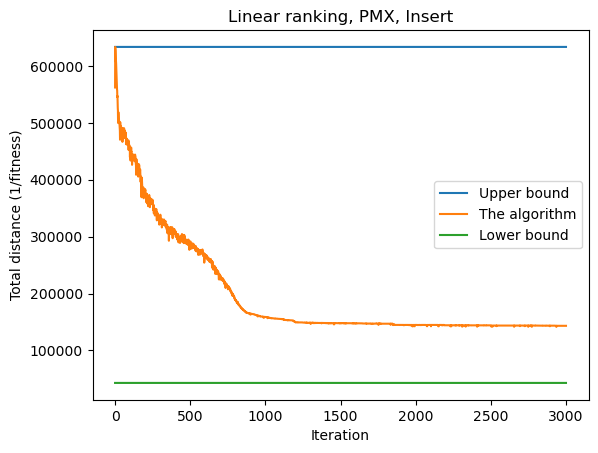

In [35]:
plt.plot([upper_bound]*ITERATIONS_NUM)
plt.plot([1/individual.fitness for individual in best_individual_each_generation])
plt.plot([lower_bound]*ITERATIONS_NUM)
plt.xlabel('Iteration')
plt.ylabel('Total distance (1/fitness)')
plt.title('Linear ranking, PMX, Insert')
plt.legend(['Upper bound', 'The algorithm', 'Lower bound'])
plt.show()